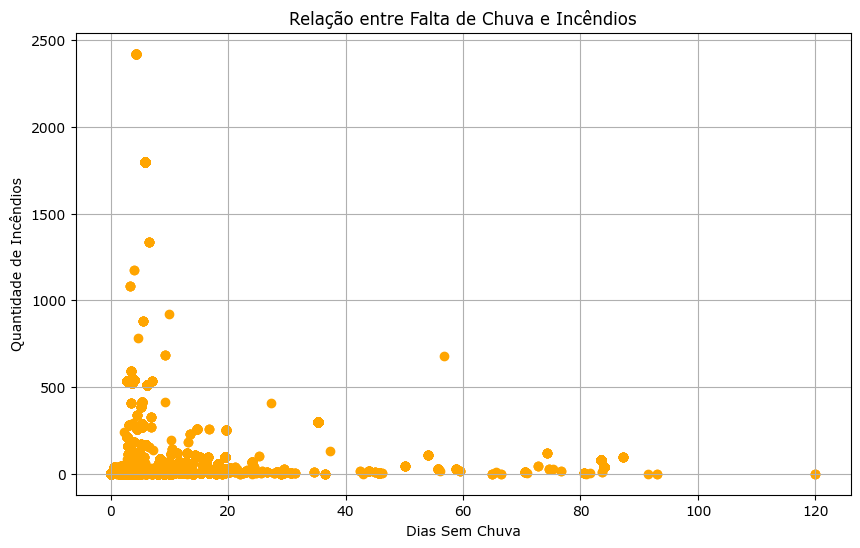

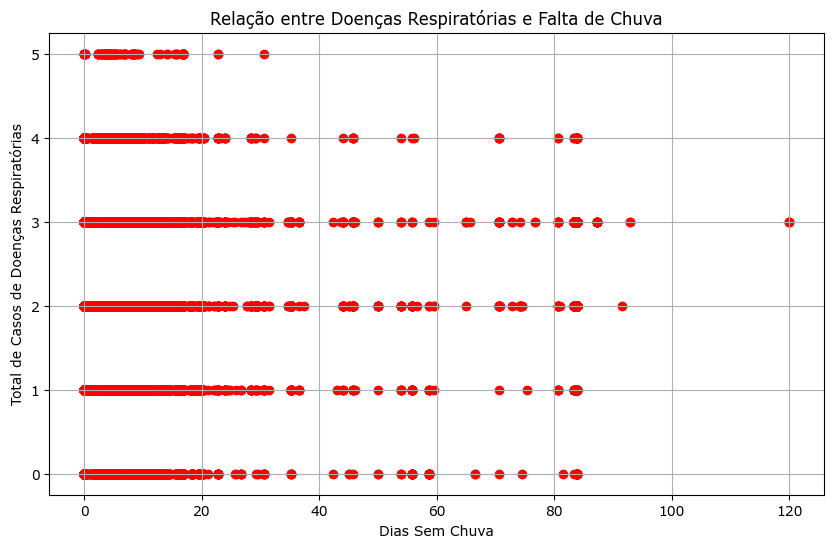

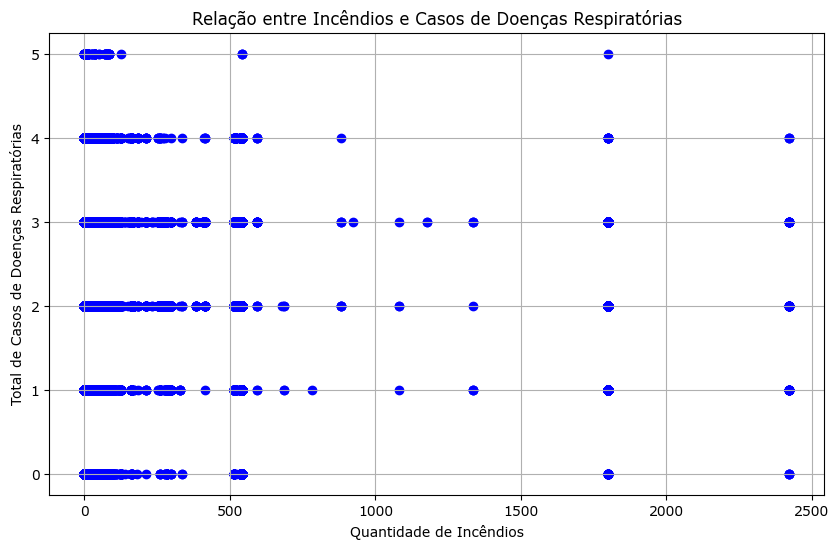

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Biblioteca opcional para estilizar os gráficos
import unidecode  # Certifique-se de que o unidecode está instalado com "pip install unidecode"
import re

# Dicionário de conversão de estados para siglas
estado_para_sigla = {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPÁ": "AP", "AMAZONAS": "AM",
    "BAHIA": "BA", "CEARÁ": "CE", "DISTRITO FEDERAL": "DF", "ESPÍRITO SANTO": "ES",
    "GOIÁS": "GO", "MARANHÃO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG", "PARÁ": "PA", "PARAÍBA": "PB", "PARANÁ": "PR",
    "PERNAMBUCO": "PE", "PIAUÍ": "PI", "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS", "RONDÔNIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC",
    "SÃO PAULO": "SP", "SERGIPE": "SE", "TOCANTINS": "TO"
}

# Função para normalizar textos (remover acentos e caracteres especiais)
def normalize_text(text):
    text = unidecode.unidecode(text.strip().upper())
    return re.sub(r'[^A-Z\s]', '', text)  # Remove caracteres indesejados

# Carregar os dados de queimadas e de saúde
queimadas = pd.read_excel("DadosQueimadas.xlsx")
saude = pd.read_excel("DadosSaude.xlsx")

# Normalizar e corrigir municípios e estados nos dados de queimadas
queimadas['Municipio'] = queimadas['Municipio'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].map(estado_para_sigla)
queimadas = queimadas.dropna(subset=['Estado', 'Municipio'])

# Normalizar colunas de município e estado no dataset de saúde
saude['ID_MUNICIP'] = saude['ID_MUNICIP'].apply(normalize_text)
saude['SG_UF_NOT'] = saude['SG_UF_NOT'].apply(normalize_text)

# Criar uma coluna de total de sintomas respiratórios no DataFrame de saúde
saude['Total_Casos_Doencas_Respiratorias'] = saude[['TOSSE', 'DISPNEIA', 'DESC_RESP', 'ASMA', 'PNEUMOPATI']].apply(
    lambda x: (x == 1).sum(), axis=1
)

# Adicionar uma coluna para contar cada ocorrência de incêndio
queimadas['Incendios_Contagem'] = 1

# Agrupar os dados de queimadas por Município e Estado, apenas somando a contagem de incêndios e média de dias sem chuva
queimadas_agrupadas = queimadas.groupby(['Municipio', 'Estado']).agg({
    'Incendios_Contagem': 'sum',  # Contagem de incêndios
    'DiaSemChuva': 'mean'          # Média de dias sem chuva
}).reset_index()

# Mesclar os dados de saúde com os dados agregados de queimadas
dados_combinados = pd.merge(saude, queimadas_agrupadas, left_on=['ID_MUNICIP', 'SG_UF_NOT'], right_on=['Municipio', 'Estado'], how='inner')

# 1. Gráfico de Dispersão: Relação entre Falta de Chuva e Incêndios
plt.figure(figsize=(10, 6))
plt.scatter(dados_combinados['DiaSemChuva'], dados_combinados['Incendios_Contagem'], color='orange')
plt.title('Relação entre Falta de Chuva e Incêndios')
plt.xlabel('Dias Sem Chuva')
plt.ylabel('Quantidade de Incêndios')
plt.grid()
plt.show()

# 2. Gráfico de Dispersão: Relação entre Doenças Respiratórias e Falta de Chuva
plt.figure(figsize=(10, 6))
plt.scatter(dados_combinados['DiaSemChuva'], dados_combinados['Total_Casos_Doencas_Respiratorias'], color='red')
plt.title('Relação entre Doenças Respiratórias e Falta de Chuva')
plt.xlabel('Dias Sem Chuva')
plt.ylabel('Total de Casos de Doenças Respiratórias')
plt.grid()
plt.show()

# 3. Gráfico de Dispersão: Relação entre Incêndios e Casos de Doenças Respiratórias
plt.figure(figsize=(10, 6))
plt.scatter(dados_combinados['Incendios_Contagem'], dados_combinados['Total_Casos_Doencas_Respiratorias'], color='blue')
plt.title('Relação entre Incêndios e Casos de Doenças Respiratórias')
plt.xlabel('Quantidade de Incêndios')
plt.ylabel('Total de Casos de Doenças Respiratórias')
plt.grid()
plt.show()
